In [1]:
import os
import json
import h5py
import pyccl
import scipy
import numpy
from matplotlib import pyplot
from matplotlib.gridspec import GridSpec

In [2]:
#Data path

TYPE = 'Z'
PATH = '/pscratch/sd/y/yhzhang/TensorCloud/'

DATA_PATH = PATH + 'DATA/'
PLOT_PATH = PATH + 'PLOT/' + TYPE + '/'

In [3]:
#Load in Data

BIN_SIZE = 4
GRID_SIZE = 128
LATENT_SIZE = 32
DATA_SIZE = 100000

with h5py.File(DATA_PATH + 'DATA.hdf5','r') as DATA:
    
    REDSHIFT_GRID = numpy.array(DATA['realizations/z'][:GRID_SIZE], dtype = 'double')
    DATA_GRID = numpy.array(DATA['realizations/pdfs'][:, :BIN_SIZE, :GRID_SIZE], dtype = 'double')

In [4]:
# COSMOLOGY

with open(DATA_PATH + 'COSMO.json', 'r') as cosmo:
    
    COSMO = json.load(cosmo)

COSMO_CCL = pyccl.Cosmology(
    h = COSMO['H'],
    w0 = COSMO['W0'],
    wa = COSMO['WA'], 
    n_s = COSMO['NS'], 
    A_s = COSMO['AS'],
    m_nu = COSMO['MNU'],  
    Neff = COSMO['NEFF'],
    T_CMB = COSMO['TCMB'], 
    Omega_k = COSMO['OMEGAK'], 
    Omega_c = COSMO['OMEGAC'], 
    Omega_b = COSMO['OMEGAB'], 
    matter_power_spectrum = 'halofit',  
    transfer_function = 'boltzmann_camb', 
    extra_parameters = {'camb': {'kmax': 100, 'lmax': 10000, 'halofit_version': 'mead2020_feedback', 'HMCode_logT_AGN': 7.8}}
)

In [5]:
#Define Kernel

def Ker_m(chi_data, chi_grid, phi_grid, growth_grid):

    bin_size = phi_grid.shape[0]
    data_size = chi_data.shape[0] - 1
    grid_size = chi_grid.shape[0] - 1
    Ker = numpy.zeros((bin_size, data_size + 1))

    for k in range(data_size + 1):
        
        n = numpy.max(numpy.where(chi_grid <= chi_data[k]))

        if n < grid_size:

            Ker[:,k] = ((chi_grid[n + 1] - chi_data[k]) / (chi_grid[n + 1] - chi_grid[n]) * phi_grid[:,n] + (chi_data[k] - chi_grid[n]) / (chi_grid[n + 1] - chi_grid[n]) * phi_grid[:,n + 1])/\
            ((chi_grid[n + 1] - chi_data[k]) / (chi_grid[n + 1] - chi_grid[n]) * growth_grid[n] + (chi_data[k] - chi_grid[n]) / (chi_grid[n + 1] - chi_grid[n]) * growth_grid[n + 1])
        else:

            Ker[:,k] = 0.0
    
    return Ker

In [10]:
#Compare different numeric equations

PSI_GRID = numpy.mean(DATA_GRID, axis = 0)
SIGMA_GRID = numpy.std(DATA_GRID, axis = 0)
A_GRID = numpy.array(1 / (1 + REDSHIFT_GRID), dtype = 'double')


CHI_GRID = COSMO_CCL.comoving_radial_distance(a = A_GRID)
PHI_GRID = PSI_GRID * COSMO_CCL.h_over_h0(a = 1 / (1 + REDSHIFT_GRID)) * COSMO['H'] * 100000 / scipy.constants.c

CHI_SIZE = 1000
REDSHIFT_DATA = numpy.linspace(REDSHIFT_GRID.min(), REDSHIFT_GRID.max(), CHI_SIZE + 1)

CHI_DATA = COSMO_CCL.comoving_radial_distance(a = 1 / (1 + REDSHIFT_DATA))
A_DATA = pyccl.background.scale_factor_of_chi(cosmo = COSMO_CCL, chi = CHI_DATA)
GROWTH_RATE = pyccl.background.growth_rate(cosmo=COSMO_CCL,a = A_GRID)
IA_bias=[REDSHIFT_GRID, numpy.ones(len(REDSHIFT_GRID))]
KERNEL_CCL = numpy.zeros((BIN_SIZE, CHI_SIZE + 1))
amplitude=pyccl.background.rho_x(cosmo=COSMO_CCL, a=1, species='critical', is_comoving=True)*(COSMO['OMEGAM'] + COSMO['OMEGAN'])* 5e-14
KERNEL_DATA = Ker_m(chi_data = CHI_DATA, chi_grid = CHI_GRID, phi_grid = PHI_GRID, growth_grid = GROWTH_RATE)

for BIN_INDEX in range(BIN_SIZE):
    TRACER = pyccl.tracers.WeakLensingTracer(cosmo = COSMO_CCL, dndz = [REDSHIFT_GRID, PSI_GRID[BIN_INDEX,:]], has_shear = False, ia_bias = IA_bias, use_A_ia = True, n_samples = GRID_SIZE)
    KERNEL_CCL[BIN_INDEX, :] = TRACER.get_kernel(chi = CHI_DATA)


KERNEL_DATA1 = scipy.interpolate.interp1d(CHI_GRID, PHI_GRID/GROWTH_RATE, kind = 'slinear')(CHI_DATA)
KERNEL_DATA2 = scipy.interpolate.interp1d(CHI_GRID, PHI_GRID/GROWTH_RATE, kind = 'quadratic')(CHI_DATA)
KERNEL_DATA3 = scipy.interpolate.interp1d(CHI_GRID, PHI_GRID/GROWTH_RATE, kind = 'cubic')(CHI_DATA)
ratio=KERNEL_DATA[0,23]/KERNEL_CCL[0,23]
KERNEL_CCL=KERNEL_CCL*ratio
print(ratio)
KERNEL_RATIO = numpy.divide(KERNEL_DATA, KERNEL_CCL, out = numpy.ones(KERNEL_CCL.shape), where = KERNEL_CCL > 0)
KERNEL_RATIO1 = numpy.divide(KERNEL_DATA1, KERNEL_CCL, out = numpy.ones(KERNEL_CCL.shape), where = KERNEL_CCL > 0)
KERNEL_RATIO2 = numpy.divide(KERNEL_DATA2, KERNEL_CCL, out = numpy.ones(KERNEL_CCL.shape), where = KERNEL_CCL > 0)
KERNEL_RATIO3 = numpy.divide(KERNEL_DATA3, KERNEL_CCL, out = numpy.ones(KERNEL_CCL.shape), where = KERNEL_CCL > 0)


2.0724432548240705


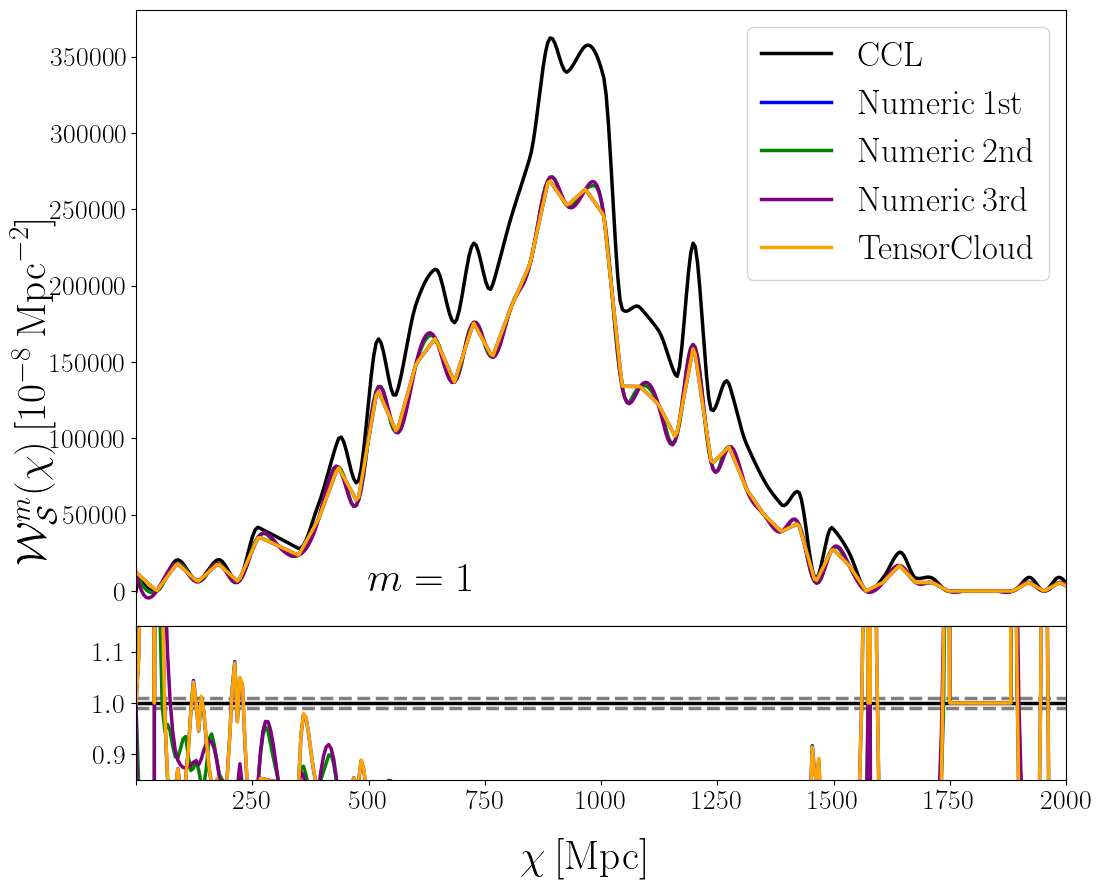

In [11]:
#Plot the results

BIN_INDEX = 0
KERNEL0 = 1e-8
pyplot.rcParams['font.size'] = 20
pyplot.rcParams['text.usetex'] = True
FIGURE = pyplot.figure(figsize = (12, 10))
GRIDSPEC = GridSpec(10, 12, figure = FIGURE, wspace = 0.0, hspace = 0.0)

PLOT = FIGURE.add_subplot(GRIDSPEC[0:8,:])

PLOT.plot(CHI_DATA, KERNEL_CCL[BIN_INDEX,:] / KERNEL0, color = 'black', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{CCL}$')

PLOT.plot(CHI_DATA, KERNEL_DATA1[BIN_INDEX,:] / KERNEL0, color = 'blue', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 1st}$')

PLOT.plot(CHI_DATA, KERNEL_DATA2[BIN_INDEX,:] / KERNEL0, color = 'green', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 2nd}$')

PLOT.plot(CHI_DATA, KERNEL_DATA3[BIN_INDEX,:] / KERNEL0, color = 'purple', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 3rd}$')

PLOT.plot(CHI_DATA, KERNEL_DATA[BIN_INDEX,:] / KERNEL0, color = 'orange', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{TensorCloud}$')

PLOT.text(x = 500, y = 100, s = r'$m = {:.0f}$'.format(BIN_INDEX + 1), fontsize = 30)

PLOT.set_xlim(0, 2000)
PLOT.legend(loc = 'upper right', fontsize = 25)

PLOT.set_xticklabels([])
PLOT.get_yticklabels()[0].set_visible([])

PLOT = FIGURE.add_subplot(GRIDSPEC[8:,:])

PLOT.plot(CHI_DATA, numpy.ones(CHI_SIZE + 1), color = 'black', linestyle = '-', linewidth = 2.5)

PLOT.plot(CHI_DATA, numpy.ones(CHI_SIZE + 1) * (1.00 + 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)

PLOT.plot(CHI_DATA, numpy.ones(CHI_SIZE + 1) * (1.00 - 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)
          
PLOT.plot(CHI_DATA, KERNEL_RATIO1[BIN_INDEX,:], color = 'blue', linestyle = '-', linewidth = 2.5)

PLOT.plot(CHI_DATA, KERNEL_RATIO2[BIN_INDEX,:], color = 'green', linestyle = '-', linewidth = 2.5)

PLOT.plot(CHI_DATA, KERNEL_RATIO3[BIN_INDEX,:], color = 'purple', linestyle = '-', linewidth = 2.5)

PLOT.plot(CHI_DATA, KERNEL_RATIO[BIN_INDEX,:], color = 'orange', linestyle = '-', linewidth = 2.5)

PLOT.set_xlim(0, 2000)
PLOT.set_ylim(1.000 - 0.15, 1.0 + 0.15)
PLOT.get_xticklabels()[0].set_visible([])

FIGURE.supxlabel(r'$\chi \: [\mathrm{Mpc}]$', fontsize = 30)
FIGURE.supylabel(r'$\mathcal{W}_\mathcal{S}^m (\chi) \: [10^{-8} \: \mathrm{Mpc}^{-2}]$', fontsize = 30)

FIGURE.subplots_adjust(hspace = 0.0, wspace = 0.0)
FIGURE.savefig(PLOT_PATH + 'KERNEL_IA.pdf', bbox_inches = 'tight')

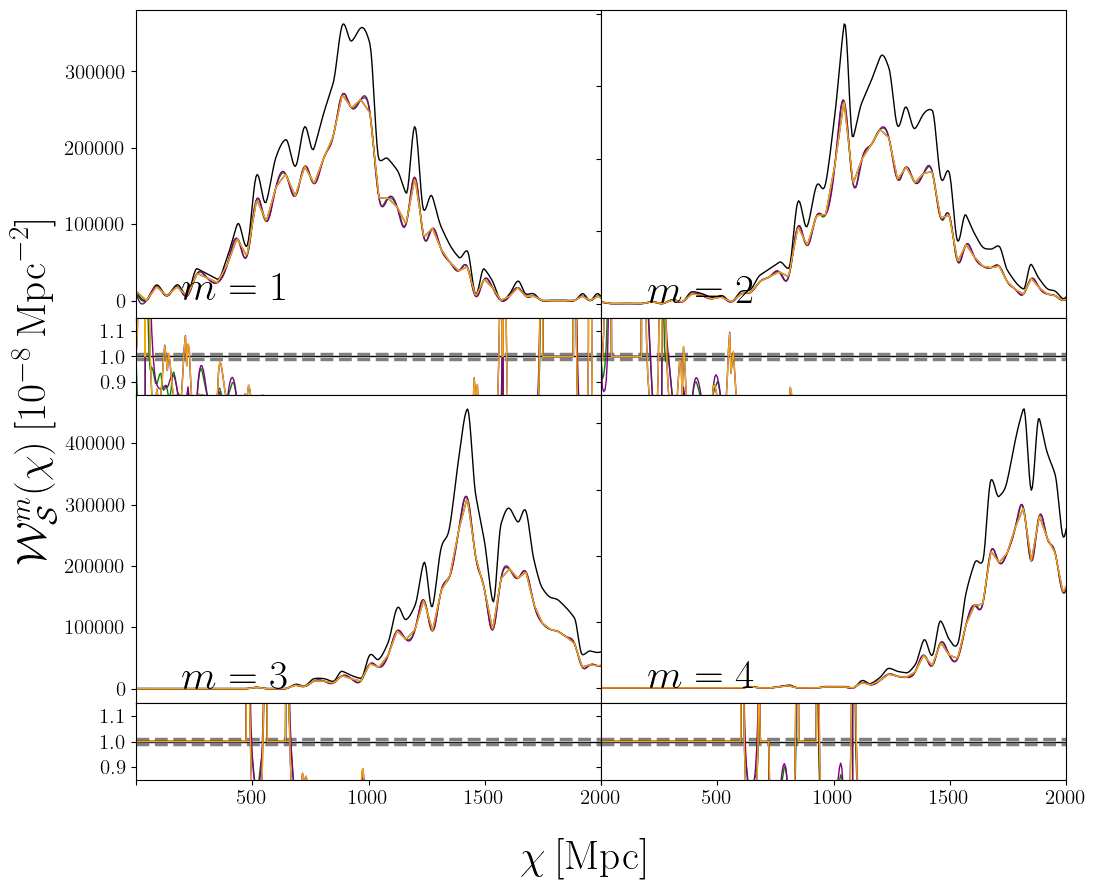

In [12]:
#Compare different bins

pyplot.rcParams['font.size'] = 15
pyplot.rcParams['text.usetex'] = True
FIGURE = pyplot.figure(figsize = (12, 10))
GRIDSPEC = GridSpec(10, 12, figure = FIGURE, wspace = 0.0, hspace = 0.0)

KERNEL0 = 1e-8
for BIN_INDEX in range(BIN_SIZE):

    ROW = BIN_INDEX//2
    COLUMN = BIN_INDEX%2
   
    PLOT = FIGURE.add_subplot(GRIDSPEC[ROW * 5: ROW * 5 + 4, COLUMN * 6: COLUMN * 6 + 6])

    PLOT.plot(CHI_DATA, KERNEL_CCL[BIN_INDEX,:] / KERNEL0, color = 'black', linestyle = '-', linewidth = 1.0)

    PLOT.plot(CHI_DATA, KERNEL_DATA1[BIN_INDEX,:] / KERNEL0, color = 'blue', linestyle = '-', linewidth = 1.0)

    PLOT.plot(CHI_DATA, KERNEL_DATA2[BIN_INDEX,:] / KERNEL0, color = 'green', linestyle = '-', linewidth = 1.0)
    
    PLOT.plot(CHI_DATA, KERNEL_DATA3[BIN_INDEX,:] / KERNEL0, color = 'purple', linestyle = '-', linewidth = 1.0)

    PLOT.plot(CHI_DATA, KERNEL_DATA[BIN_INDEX,:] / KERNEL0, color = 'orange', linestyle = '-', linewidth = 1.0)

    PLOT.text(x = 200, y = 100, s = r'$m = {:.0f}$'.format(BIN_INDEX + 1), fontsize = 30)

    PLOT.set_xlim(0, 2000)
    #PLOT.set_ylim(0, 1350)

    PLOT.set_xticklabels([])
    if COLUMN > 0: PLOT.set_yticklabels([])
    PLOT.get_xticklabels()[0].set_visible([])
    PLOT.get_yticklabels()[0].set_visible([])

    PLOT = FIGURE.add_subplot(GRIDSPEC[ROW * 5 + 4: ROW * 5 + 5, COLUMN * 6: COLUMN * 6 + 6])

    PLOT.plot(CHI_DATA, numpy.ones(CHI_SIZE + 1), color = 'black', linestyle = '-', linewidth = 1.0)

    PLOT.plot(CHI_DATA, numpy.ones(CHI_SIZE + 1) * (1.00 + 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)

    PLOT.plot(CHI_DATA, numpy.ones(CHI_SIZE + 1) * (1.00 - 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)

    PLOT.plot(CHI_DATA, KERNEL_RATIO1[BIN_INDEX,:], color = 'blue', linestyle = '-', linewidth = 1.0)

    PLOT.plot(CHI_DATA, KERNEL_RATIO2[BIN_INDEX,:], color = 'green', linestyle = '-', linewidth = 1.0)
    
    PLOT.plot(CHI_DATA, KERNEL_RATIO3[BIN_INDEX,:], color = 'purple', linestyle = '-', linewidth = 1.0)

    PLOT.plot(CHI_DATA, KERNEL_RATIO[BIN_INDEX,:], color = 'orange', linestyle = '-', linewidth = 1.0)

    PLOT.set_xlim(0, 2000)
    PLOT.set_ylim(1.000 - 0.15, 1.0 + 0.15)

    if ROW == 0: PLOT.set_xticklabels([])
    if COLUMN > 0: PLOT.set_yticklabels([])
    PLOT.get_xticklabels()[0].set_visible([])

FIGURE.supxlabel(r'$\chi \: [\mathrm{Mpc}]$', fontsize = 30)
FIGURE.supylabel(r'$\mathcal{W}_\mathcal{S}^m (\chi)  \: [10^{-8} \: \mathrm{Mpc}^{-2}]$', fontsize = 30)

FIGURE.subplots_adjust(hspace = 0.0, wspace = 0.0)
FIGURE.savefig(PLOT_PATH + 'KERNEL_M_IA.pdf', bbox_inches = 'tight')

In [9]:
print(1 / COSMO['H'] )

1.485442662630535
